Transfer learning: Feature Extraction



In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 27.6 MB/s eta 0:00:00


In [ ]:
from torchvision import models
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision.datasets import FashionMNIST
from torchmetrics import Accuracy
import matplotlib.pyplot as plt

# Load a pre-trained ResNet
model = models.resnet50(weights='IMAGENET1K_V2')

# Freeze all the layers - keep the learned features
for param in model.parameters():
    param.requires_grad = False

# Replace just the final layer
model.fc = nn.Linear(model.fc.in_features, 10)


In [ ]:
classes = [
    "airplane", "automobile", "bird", "cat",
    "deer", "dog", "frog", "horse", "ship",
    "truck"
]


transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225]) ])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]) ])

train_dataset = datasets.CIFAR10(
    root='./data',
    train=True, # Train dataset
    download=True,
    transform=transform_train)

test_dataset = datasets.CIFAR10(
    root='./data',
    train=False, # Test dataset
    download=True,
    transform=transform_test)

# create dataloader
training_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    drop_last=True)
testing_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)


EPOCHS = 5
total_epoch_count = []

accuracy_mc = Accuracy(task="multiclass", num_classes=10).to(device)

total_training_loss, total_testing_loss = [], []
total_train_acc, total_test_acc = [], []
epoch_count = []

for epoch in range(EPOCHS):

    model.train()
    train_loss, train_acc = 0, 0
    accuracy_mc.reset()

    for X, y in training_dataloader:
        X, y = X.to(device), y.to(device)

        logits = model(X)
        loss = loss_fn(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred = logits.argmax(1)

        train_loss += loss.item()
        train_acc += accuracy_mc(y_pred, y)

    avg_train_loss = train_loss / len(training_dataloader)
    avg_train_acc = train_acc / len(training_dataloader)

    # ---- Testing ----
    model.eval()
    test_loss, test_acc = 0, 0
    accuracy_mc.reset()

    with torch.no_grad():
        for X, y in testing_dataloader:
            X, y = X.to(device), y.to(device)

            logits = model(X)
            loss = loss_fn(logits, y)
            y_pred = logits.argmax(1)

            test_loss += loss.item()
            test_acc += accuracy_mc(y_pred, y)

    avg_test_loss = test_loss / len(testing_dataloader)
    avg_test_acc  = test_acc / len(testing_dataloader)

    total_training_loss.append(avg_train_loss)
    total_testing_loss.append(avg_test_loss)
    total_train_acc.append(avg_train_acc.item())
    total_test_acc.append(avg_test_acc.item())
    epoch_count.append(epoch)

    print(f"Epoch {epoch}: "
          f"train_loss={avg_train_loss:.3f} "
          f"train_acc={avg_train_acc:.3f} "
          f"test_loss={avg_test_loss:.3f} "
          f"test_acc={avg_test_acc:.3f}")


Epoch 0: train_loss=1.358 train_acc=0.526 test_loss=0.872 test_acc=0.698
Epoch 1: train_loss=1.192 train_acc=0.586 test_loss=0.787 test_acc=0.732
Epoch 2: train_loss=1.157 train_acc=0.596 test_loss=0.753 test_acc=0.744
Epoch 3: train_loss=1.140 train_acc=0.602 test_loss=0.736 test_acc=0.747
Epoch 4: train_loss=1.132 train_acc=0.606 test_loss=0.743 test_acc=0.741
Epoch 5: train_loss=1.125 train_acc=0.608 test_loss=0.732 test_acc=0.750
Epoch 6: train_loss=1.118 train_acc=0.609 test_loss=0.710 test_acc=0.759
Epoch 7: train_loss=1.107 train_acc=0.612 test_loss=0.718 test_acc=0.749
Epoch 8: train_loss=1.107 train_acc=0.616 test_loss=0.705 test_acc=0.757
Epoch 9: train_loss=1.102 train_acc=0.615 test_loss=0.725 test_acc=0.749
Epoch 10: train_loss=1.102 train_acc=0.616 test_loss=0.691 test_acc=0.764
Epoch 11: train_loss=1.099 train_acc=0.617 test_loss=0.709 test_acc=0.755


KeyboardInterrupt: 

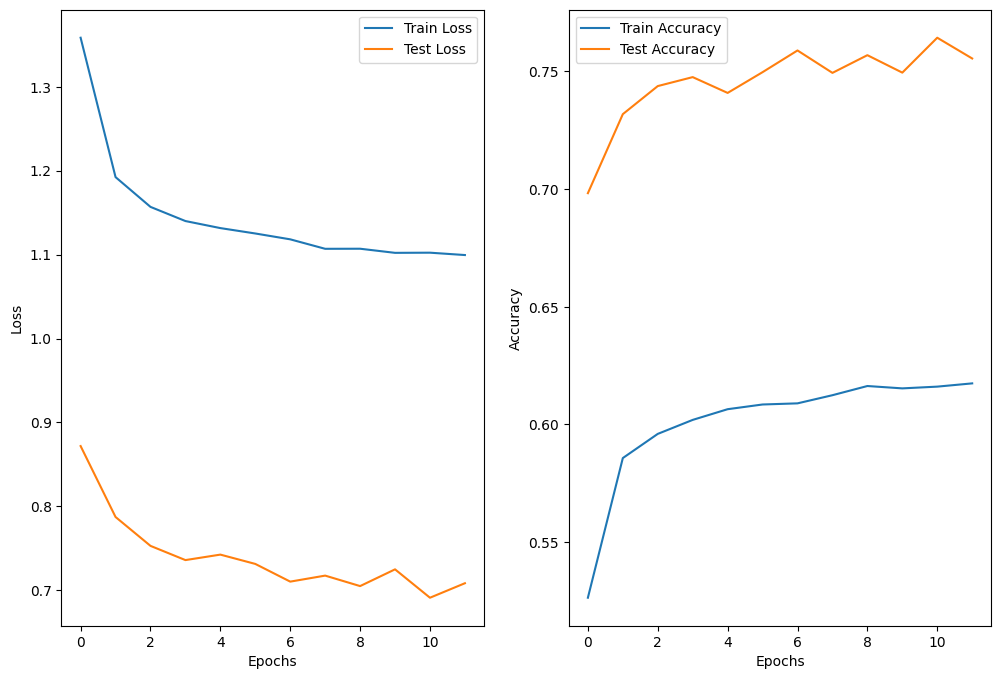

In [ ]:
figure = plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(epoch_count, total_training_loss, label='Train Loss')
plt.plot(epoch_count, total_testing_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epoch_count, total_train_acc, label='Train Accuracy')
plt.plot(epoch_count, total_test_acc, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()